# 🎯 Training DeepLabV3+ với ResNet Backbone

Notebook này thực hiện training model **DeepLabV3+ với ResNet backbone** cho bài toán phân đoạn khối u da:

## 🎯 Model: DeepLabV3+ + ResNet
- **Architecture**: DeepLabV3+ với ResNet-50 encoder
- **Backbone**: ResNet-50 (pre-trained trên ImageNet)
- **Parameters**: ~39.6M
- **Ưu điểm**: Robust, xử lý tốt multi-scale objects, ASPP module cho multi-scale features
- **Learning Rate Scheduler**: StepLR (scheduled decay)

## 📊 Training Configuration:
- **Epochs**: 15
- **Learning Rate**: 1e-4
- **Batch Size**: 8
- **Optimizer**: Adam với weight decay 1e-4
- **Loss Function**: Combined Loss (BCE + Dice)
- **Metrics**: Dice Coefficient, Jaccard Index (IoU)
- **Scheduler**: StepLR (step_size=5, gamma=0.1)

## 1. Import thư viện và setup

In [9]:
# Cài đặt các thư viện cần thiết
!pip install segmentation-models-pytorch timm torch torchvision
!pip install albumentations opencv-python-headless
!pip install matplotlib seaborn scikit-learn pillow tqdm

In [10]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# Segmentation models
import segmentation_models_pytorch as smp

# Timm for backbone
import timm

# Albumentations for augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Metrics
from sklearn.metrics import jaccard_score, f1_score

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Tạo thư mục models nếu chưa có
os.makedirs('models', exist_ok=True)
print("✅ Setup hoàn tất!")

Using device: cuda
✅ Setup hoàn tất!


## 2. Dataset và Data Augmentation

In [11]:
class ISICDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None, target_size=(512, 512)):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.target_size = target_size
        
        # Lấy danh sách file images
        self.image_files = sorted([f for f in os.listdir(images_dir) 
                                 if f.endswith(('.jpg', '.jpeg', '.png'))])
        
        print(f"Found {len(self.image_files)} images in {images_dir}")
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        # Load image
        img_name = self.image_files[idx]
        img_path = os.path.join(self.images_dir, img_name)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Find corresponding mask
        base_name = os.path.splitext(img_name)[0]
        possible_mask_names = [
            f"{base_name}_segmentation.png",
            f"{base_name}_mask.png",
            f"{base_name}.png"
        ]
        
        mask = None
        for mask_name in possible_mask_names:
            mask_path = os.path.join(self.masks_dir, mask_name)
            if os.path.exists(mask_path):
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                break
        
        if mask is None:
            # Create dummy mask if not found
            mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
        
        # Resize
        image = cv2.resize(image, self.target_size)
        mask = cv2.resize(mask, self.target_size)
        
        # Convert mask to binary
        mask = (mask > 127).astype(np.float32)
        
        # Apply augmentations
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        
        # Convert to tensor if not already
        if not isinstance(image, torch.Tensor):
            image = torch.from_numpy(image.transpose(2, 0, 1)).float() / 255.0
        
        if not isinstance(mask, torch.Tensor):
            mask = torch.from_numpy(mask).float().unsqueeze(0)
        
        return image, mask

# Define augmentations
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

print("✅ Dataset class và augmentations đã được định nghĩa!")

✅ Dataset class và augmentations đã được định nghĩa!


In [12]:
# Create datasets
train_dataset = ISICDataset(
    images_dir='data/train/images',
    masks_dir='data/train/ground_truth',
    transform=train_transform,
    target_size=(512, 512)
)

val_dataset = ISICDataset(
    images_dir='data/val/images',
    masks_dir='data/val/ground_truth',
    transform=val_transform,
    target_size=(512, 512)
)

# Create data loaders
batch_size = 8

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

print(f"📊 Dataset Summary:")
print(f"   - Training samples: {len(train_dataset)}")
print(f"   - Validation samples: {len(val_dataset)}")
print(f"   - Batch size: {batch_size}")
print(f"   - Training batches: {len(train_loader)}")
print(f"   - Validation batches: {len(val_loader)}")

Found 2594 images in data/train/images
Found 100 images in data/val/images
📊 Dataset Summary:
   - Training samples: 2594
   - Validation samples: 100
   - Batch size: 8
   - Training batches: 325
   - Validation batches: 13


## 3. DeepLabV3+ ResNet Model Definition

In [13]:
class DeepLabV3PlusResNet(nn.Module):
    def __init__(self, backbone_name="resnet50", num_classes=1, pretrained=True):
        super().__init__()
        
        # Sử dụng segmentation_models_pytorch để tạo DeepLabV3+ với ResNet backbone
        self.model = smp.DeepLabV3Plus(
            encoder_name=backbone_name,
            encoder_weights="imagenet" if pretrained else None,
            in_channels=3,
            classes=num_classes,
            activation=None  # We'll apply sigmoid manually
        )
        
        print(f"✅ DeepLabV3+ ResNet model created:")
        print(f"   - Backbone: {backbone_name}")
        print(f"   - Pre-trained: {pretrained}")
        print(f"   - Number of classes: {num_classes}")
        print(f"   - Features: ASPP module, multi-scale processing")
        
    def forward(self, x):
        # Forward pass through DeepLabV3+
        logits = self.model(x)
        
        # Apply sigmoid for binary segmentation
        return torch.sigmoid(logits)

# Initialize model
print("🎯 Initializing DeepLabV3+ ResNet model...")
model = DeepLabV3PlusResNet(
    backbone_name="resnet50",
    num_classes=1,
    pretrained=True
)
model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"📊 Model Statistics:")
print(f"   - Total parameters: {total_params:,}")
print(f"   - Trainable parameters: {trainable_params:,}")
print(f"   - Model size: ~{total_params/1e6:.1f}M parameters")

🎯 Initializing DeepLabV3+ ResNet model...


✅ DeepLabV3+ ResNet model created:
   - Backbone: resnet50
   - Pre-trained: True
   - Number of classes: 1
   - Features: ASPP module, multi-scale processing
📊 Model Statistics:
   - Total parameters: 26,677,585
   - Trainable parameters: 26,677,585
   - Model size: ~26.7M parameters


## 4. Loss Functions và Metrics

In [14]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth
        
    def forward(self, pred, target):
        pred = pred.view(-1)
        target = target.view(-1)
        
        intersection = (pred * target).sum()
        dice = (2. * intersection + self.smooth) / (pred.sum() + target.sum() + self.smooth)
        
        return 1 - dice

class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.5):
        super().__init__()
        self.alpha = alpha
        self.bce = nn.BCELoss()
        self.dice = DiceLoss()
        
    def forward(self, pred, target):
        # Ensure pred and target have the same shape
        # pred: [batch, 1, H, W], target: [batch, H, W]
        if pred.dim() == 4 and target.dim() == 3:
            pred = pred.squeeze(1)  # Remove channel dimension: [batch, H, W]
        elif pred.dim() == 3 and target.dim() == 4:
            target = target.squeeze(1)  # Remove channel dimension: [batch, H, W]
        
        return self.alpha * self.bce(pred, target) + (1 - self.alpha) * self.dice(pred, target)

def calculate_dice_batch(pred, target, threshold=0.5):
    """Calculate Dice coefficient for a batch"""
    # Ensure pred and target have the same shape
    if pred.dim() == 4 and target.dim() == 3:
        pred = pred.squeeze(1)  # Remove channel dimension
    elif pred.dim() == 3 and target.dim() == 4:
        target = target.squeeze(1)  # Remove channel dimension
    
    pred_binary = (pred > threshold).float()
    target_binary = target.float()
    
    intersection = (pred_binary * target_binary).sum()
    dice = (2. * intersection) / (pred_binary.sum() + target_binary.sum() + 1e-6)
    
    return dice.item()

def calculate_jaccard_batch(pred, target):
    """Calculate Jaccard Index (IoU) for a batch"""
    # Ensure pred and target have the same shape
    if pred.dim() == 4 and target.dim() == 3:
        pred = pred.squeeze(1)  # Remove channel dimension
    elif pred.dim() == 3 and target.dim() == 4:
        target = target.squeeze(1)  # Remove channel dimension
    
    # Convert to boolean for intersection and union
    pred_bool = pred.bool()
    target_bool = target.bool()
    
    intersection = (pred_bool & target_bool).float().sum()
    union = (pred_bool | target_bool).float().sum()
    
    jaccard = intersection / (union + 1e-6)
    return jaccard.item()

print("✅ Loss functions và metrics đã được định nghĩa!")

✅ Loss functions và metrics đã được định nghĩa!


## 5. Training Function với StepLR

In [15]:
def train_deeplabv3_resnet(model, train_loader, val_loader, num_epochs=15, lr=1e-4, patience=5, min_delta=0.001):
    """
    Training function for DeepLabV3+ ResNet with StepLR scheduler and Early Stopping
    
    Args:
        patience: Number of epochs to wait for improvement before stopping
        min_delta: Minimum change to qualify as an improvement
    """
    # Loss function and optimizer
    criterion = CombinedLoss(alpha=0.5)  # Combination of BCE and Dice loss
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    
    # StepLR scheduler (scheduled decay)
    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer, step_size=5, gamma=0.1
    )
    
    # Training history
    history = {
        'train_losses': [],
        'val_losses': [],
        'train_dice': [],
        'val_dice': [],
        'train_jaccard': [],
        'val_jaccard': [],
        'learning_rates': []
    }
    
    # Early stopping variables
    best_val_loss = float('inf')
    patience_counter = 0
    early_stopped = False
    
    print(f"🚀 Bắt đầu training DeepLabV3+ ResNet...")
    print(f"📊 Configuration:")
    print(f"   - Epochs: {num_epochs}")
    print(f"   - Learning Rate: {lr}")
    print(f"   - Early Stopping: Patience={patience}, Min Delta={min_delta}")
    print(f"   - Scheduler: StepLR (step_size=5, gamma=0.1)")
    print(f"   - Loss: Combined (BCE + Dice)")
    print("=" * 70)
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_dice = 0.0
        train_jaccard = 0.0
        
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Training')
        for batch_idx, (images, masks) in enumerate(train_pbar):
            images, masks = images.to(device), masks.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            # Calculate metrics
            with torch.no_grad():
                pred_masks = outputs > 0.5
                dice = calculate_dice_batch(outputs, masks)
                jaccard = calculate_jaccard_batch(pred_masks, masks.bool())
                train_dice += dice
                train_jaccard += jaccard
            
            train_loss += loss.item()
            train_pbar.set_postfix({
                'Loss': f'{loss.item():.4f}', 
                'Dice': f'{dice:.3f}', 
                'Jaccard': f'{jaccard:.3f}'
            })
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_dice = 0.0
        val_jaccard = 0.0
        
        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Validation')
            for images, masks in val_pbar:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                
                # Calculate metrics
                pred_masks = outputs > 0.5
                dice = calculate_dice_batch(outputs, masks)
                jaccard = calculate_jaccard_batch(pred_masks, masks.bool())
                val_dice += dice
                val_jaccard += jaccard
                
                val_loss += loss.item()
                val_pbar.set_postfix({
                    'Loss': f'{loss.item():.4f}', 
                    'Dice': f'{dice:.3f}', 
                    'Jaccard': f'{jaccard:.3f}'
                })
        
        # Calculate averages
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_dice /= len(train_loader)
        val_dice /= len(val_loader)
        train_jaccard /= len(train_loader)
        val_jaccard /= len(val_loader)
        
        # Update learning rate
        current_lr = optimizer.param_groups[0]['lr']
        scheduler.step()
        new_lr = optimizer.param_groups[0]['lr']
        
        # Store history
        history['train_losses'].append(train_loss)
        history['val_losses'].append(val_loss)
        history['train_dice'].append(train_dice)
        history['val_dice'].append(val_dice)
        history['train_jaccard'].append(train_jaccard)
        history['val_jaccard'].append(val_jaccard)
        history['learning_rates'].append(current_lr)
        
        # Print epoch summary
        if abs(current_lr - new_lr) > 1e-8:
            print(f"  Learning rate changed: {current_lr:.6f} -> {new_lr:.6f}")
        
        print(f"Epoch {epoch+1}/{num_epochs}:")
        print(f"  Train Loss: {train_loss:.4f}, Train Dice: {train_dice:.4f}, Train Jaccard: {train_jaccard:.4f}")
        print(f"  Val Loss: {val_loss:.4f}, Val Dice: {val_dice:.4f}, Val Jaccard: {val_jaccard:.4f}")
        print(f"  LR: {current_lr:.6f}")
        print("-" * 70)
        
        # Save best model and early stopping logic
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'models/deeplabv3_resnet_model_best.pth')
            print(f"✅ New best validation loss: {val_loss:.4f} (patience reset)")
        else:
            patience_counter += 1
            print(f"⏳ No improvement. Patience: {patience_counter}/{patience}")
            
            if patience_counter >= patience:
                print(f"\n🛑 Early stopping triggered after {epoch+1} epochs!")
                print(f"   Best validation loss: {best_val_loss:.4f}")
                early_stopped = True
                break
    
    # Training completion message
    if early_stopped:
        print(f"\n🏁 Training stopped early at epoch {epoch+1}/{num_epochs}")
    else:
        print(f"\n🏁 Training completed all {num_epochs} epochs")
    
    print(f"📊 Final best validation loss: {best_val_loss:.4f}")
    
    return history

print("✅ Training function đã được định nghĩa!")

✅ Training function đã được định nghĩa!


## 6. Bắt đầu Training

In [16]:
# Train the DeepLabV3+ ResNet model
print("🚀 Bắt đầu training DeepLabV3+ ResNet...")
print("⏰ Thời gian dự kiến: ~1-2 giờ (với early stopping)")
print()

deeplabv3_resnet_history = train_deeplabv3_resnet(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=15,
    lr=1e-4,
    patience=5,      # Dừng sớm sau 5 epochs không cải thiện
    min_delta=0.001  # Cải thiện tối thiểu 0.001 để được tính
)

# Save final model
torch.save(model.state_dict(), 'models/deeplabv3_resnet_model_final.pth')
print("\n🎉 DeepLabV3+ ResNet training hoàn thành!")
print("💾 Model đã được lưu:")
print("   - models/deeplabv3_resnet_model_best.pth (best validation loss)")
print("   - models/deeplabv3_resnet_model_final.pth (final epoch)")

🚀 Bắt đầu training DeepLabV3+ ResNet...
⏰ Thời gian dự kiến: ~1-2 giờ (với early stopping)

🚀 Bắt đầu training DeepLabV3+ ResNet...
📊 Configuration:
   - Epochs: 15
   - Learning Rate: 0.0001
   - Early Stopping: Patience=5, Min Delta=0.001
   - Scheduler: StepLR (step_size=5, gamma=0.1)
   - Loss: Combined (BCE + Dice)


Epoch 1/15 - Validation: 100%|██████████| 13/13 [00:02<00:00,  5.18it/s, Loss=0.1154, Dice=0.922, Jaccard=0.855]


Epoch 1/15:
  Train Loss: 0.2640, Train Dice: 0.8241, Train Jaccard: 0.7141
  Val Loss: 0.1667, Val Dice: 0.8823, Val Jaccard: 0.7964
  LR: 0.000100
----------------------------------------------------------------------
✅ New best validation loss: 0.1667 (patience reset)


Epoch 2/15 - Validation: 100%|██████████| 13/13 [00:02<00:00,  5.12it/s, Loss=0.1962, Dice=0.835, Jaccard=0.716]


Epoch 2/15:
  Train Loss: 0.1618, Train Dice: 0.8726, Train Jaccard: 0.7802
  Val Loss: 0.1773, Val Dice: 0.8701, Val Jaccard: 0.7732
  LR: 0.000100
----------------------------------------------------------------------
⏳ No improvement. Patience: 1/5


Epoch 3/15 - Validation: 100%|██████████| 13/13 [00:02<00:00,  4.86it/s, Loss=0.1204, Dice=0.890, Jaccard=0.803]


Epoch 3/15:
  Train Loss: 0.1456, Train Dice: 0.8805, Train Jaccard: 0.7913
  Val Loss: 0.1438, Val Dice: 0.8884, Val Jaccard: 0.8029
  LR: 0.000100
----------------------------------------------------------------------
✅ New best validation loss: 0.1438 (patience reset)


Epoch 4/15 - Validation: 100%|██████████| 13/13 [00:02<00:00,  5.02it/s, Loss=0.2079, Dice=0.822, Jaccard=0.697]


Epoch 4/15:
  Train Loss: 0.1344, Train Dice: 0.8881, Train Jaccard: 0.8024
  Val Loss: 0.1728, Val Dice: 0.8683, Val Jaccard: 0.7714
  LR: 0.000100
----------------------------------------------------------------------
⏳ No improvement. Patience: 1/5


Epoch 5/15 - Validation: 100%|██████████| 13/13 [00:02<00:00,  5.12it/s, Loss=0.1102, Dice=0.911, Jaccard=0.837]


  Learning rate changed: 0.000100 -> 0.000010
Epoch 5/15:
  Train Loss: 0.1280, Train Dice: 0.8927, Train Jaccard: 0.8106
  Val Loss: 0.1782, Val Dice: 0.8639, Val Jaccard: 0.7668
  LR: 0.000100
----------------------------------------------------------------------
⏳ No improvement. Patience: 2/5


Epoch 6/15 - Validation: 100%|██████████| 13/13 [00:02<00:00,  5.25it/s, Loss=0.1024, Dice=0.907, Jaccard=0.830]


Epoch 6/15:
  Train Loss: 0.1169, Train Dice: 0.9013, Train Jaccard: 0.8235
  Val Loss: 0.1351, Val Dice: 0.8947, Val Jaccard: 0.8117
  LR: 0.000010
----------------------------------------------------------------------
✅ New best validation loss: 0.1351 (patience reset)


Epoch 7/15 - Validation: 100%|██████████| 13/13 [00:02<00:00,  5.26it/s, Loss=0.0922, Dice=0.920, Jaccard=0.851]


Epoch 7/15:
  Train Loss: 0.1066, Train Dice: 0.9104, Train Jaccard: 0.8382
  Val Loss: 0.1292, Val Dice: 0.9008, Val Jaccard: 0.8218
  LR: 0.000010
----------------------------------------------------------------------
✅ New best validation loss: 0.1292 (patience reset)


Epoch 8/15 - Validation: 100%|██████████| 13/13 [00:02<00:00,  5.19it/s, Loss=0.1091, Dice=0.901, Jaccard=0.821]


Epoch 8/15:
  Train Loss: 0.1059, Train Dice: 0.9118, Train Jaccard: 0.8406
  Val Loss: 0.1317, Val Dice: 0.8976, Val Jaccard: 0.8164
  LR: 0.000010
----------------------------------------------------------------------
⏳ No improvement. Patience: 1/5


Epoch 9/15 - Validation: 100%|██████████| 13/13 [00:02<00:00,  5.21it/s, Loss=0.1113, Dice=0.900, Jaccard=0.819]


Epoch 9/15:
  Train Loss: 0.1017, Train Dice: 0.9156, Train Jaccard: 0.8465
  Val Loss: 0.1295, Val Dice: 0.8996, Val Jaccard: 0.8192
  LR: 0.000010
----------------------------------------------------------------------
⏳ No improvement. Patience: 2/5


Epoch 10/15 - Validation: 100%|██████████| 13/13 [00:02<00:00,  5.31it/s, Loss=0.1209, Dice=0.891, Jaccard=0.804]


  Learning rate changed: 0.000010 -> 0.000001
Epoch 10/15:
  Train Loss: 0.1000, Train Dice: 0.9154, Train Jaccard: 0.8467
  Val Loss: 0.1325, Val Dice: 0.8962, Val Jaccard: 0.8143
  LR: 0.000010
----------------------------------------------------------------------
⏳ No improvement. Patience: 3/5


Epoch 11/15 - Validation: 100%|██████████| 13/13 [00:02<00:00,  5.27it/s, Loss=0.1163, Dice=0.894, Jaccard=0.809]


Epoch 11/15:
  Train Loss: 0.0985, Train Dice: 0.9165, Train Jaccard: 0.8484
  Val Loss: 0.1304, Val Dice: 0.8970, Val Jaccard: 0.8160
  LR: 0.000001
----------------------------------------------------------------------
⏳ No improvement. Patience: 4/5


Epoch 12/15 - Validation: 100%|██████████| 13/13 [00:02<00:00,  5.12it/s, Loss=0.1035, Dice=0.906, Jaccard=0.828]


Epoch 12/15:
  Train Loss: 0.0964, Train Dice: 0.9194, Train Jaccard: 0.8531
  Val Loss: 0.1280, Val Dice: 0.8997, Val Jaccard: 0.8199
  LR: 0.000001
----------------------------------------------------------------------
✅ New best validation loss: 0.1280 (patience reset)


Epoch 13/15 - Validation: 100%|██████████| 13/13 [00:02<00:00,  5.27it/s, Loss=0.1050, Dice=0.904, Jaccard=0.825]


Epoch 13/15:
  Train Loss: 0.0968, Train Dice: 0.9189, Train Jaccard: 0.8525
  Val Loss: 0.1288, Val Dice: 0.8990, Val Jaccard: 0.8187
  LR: 0.000001
----------------------------------------------------------------------
⏳ No improvement. Patience: 1/5


Epoch 14/15 - Validation: 100%|██████████| 13/13 [00:02<00:00,  5.12it/s, Loss=0.1100, Dice=0.900, Jaccard=0.819]


Epoch 14/15:
  Train Loss: 0.0968, Train Dice: 0.9189, Train Jaccard: 0.8520
  Val Loss: 0.1262, Val Dice: 0.9005, Val Jaccard: 0.8214
  LR: 0.000001
----------------------------------------------------------------------
✅ New best validation loss: 0.1262 (patience reset)


Epoch 15/15 - Validation: 100%|██████████| 13/13 [00:02<00:00,  5.23it/s, Loss=0.1043, Dice=0.907, Jaccard=0.830]


  Learning rate changed: 0.000001 -> 0.000000
Epoch 15/15:
  Train Loss: 0.0962, Train Dice: 0.9190, Train Jaccard: 0.8523
  Val Loss: 0.1228, Val Dice: 0.9045, Val Jaccard: 0.8275
  LR: 0.000001
----------------------------------------------------------------------
✅ New best validation loss: 0.1228 (patience reset)

🏁 Training completed all 15 epochs
📊 Final best validation loss: 0.1228

🎉 DeepLabV3+ ResNet training hoàn thành!
💾 Model đã được lưu:
   - models/deeplabv3_resnet_model_best.pth (best validation loss)
   - models/deeplabv3_resnet_model_final.pth (final epoch)


## 7. Visualization và Evaluation

📊 Hiển thị training history:


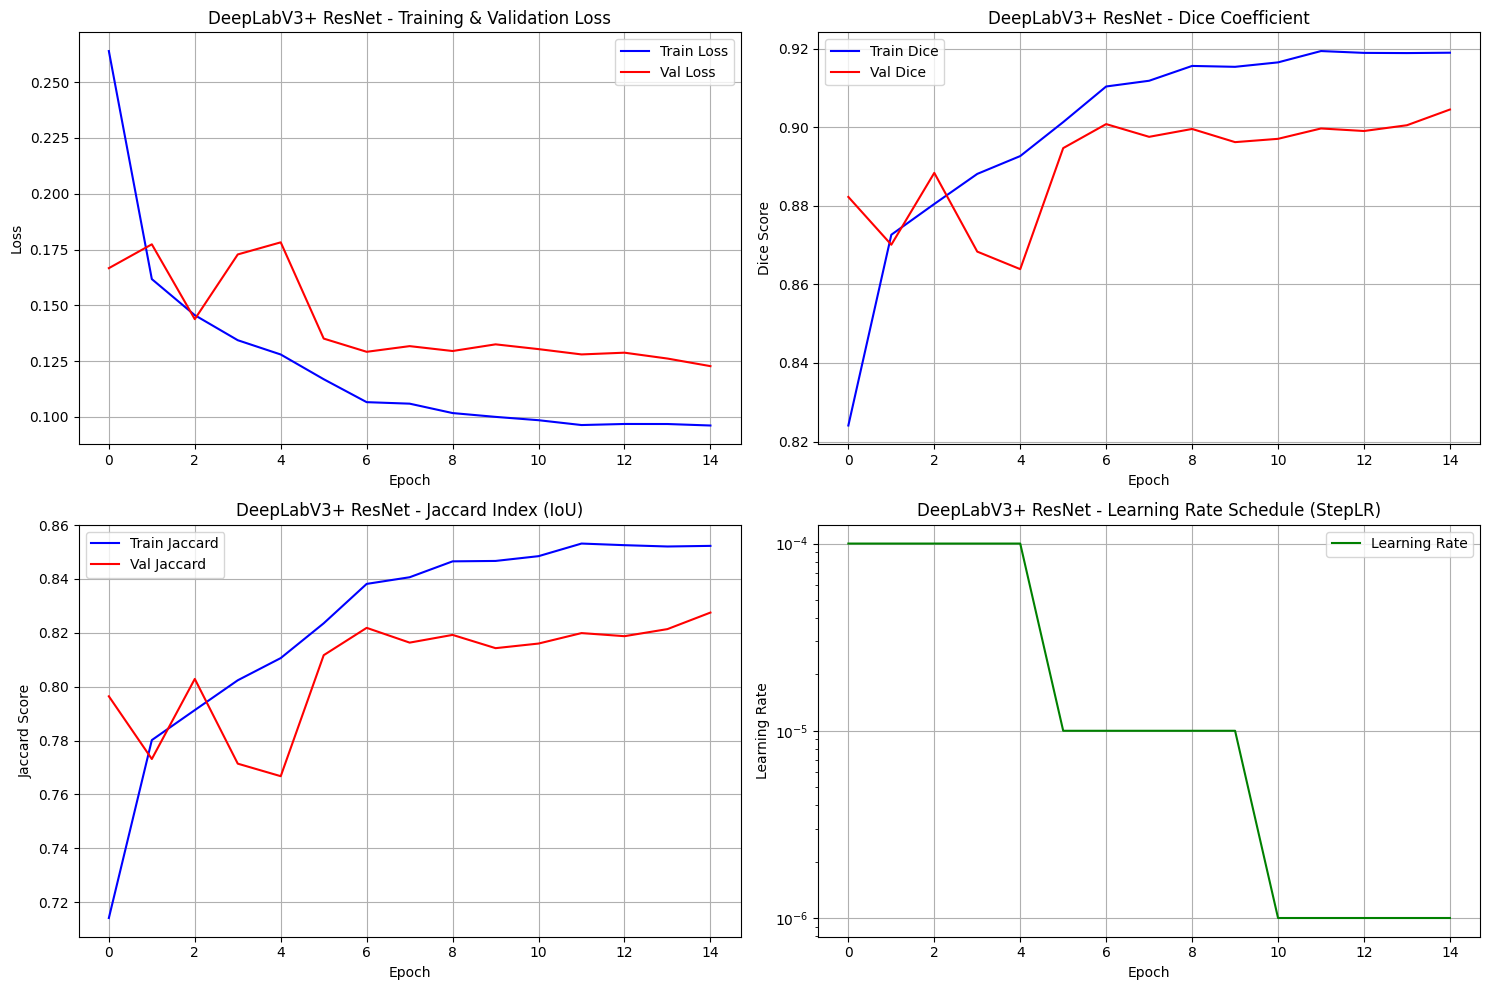

In [17]:
def plot_training_history(history, model_name="DeepLabV3+ ResNet"):
    """Plot training history"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Loss
    axes[0, 0].plot(history['train_losses'], label='Train Loss', color='blue')
    axes[0, 0].plot(history['val_losses'], label='Val Loss', color='red')
    axes[0, 0].set_title(f'{model_name} - Training & Validation Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Dice Coefficient
    axes[0, 1].plot(history['train_dice'], label='Train Dice', color='blue')
    axes[0, 1].plot(history['val_dice'], label='Val Dice', color='red')
    axes[0, 1].set_title(f'{model_name} - Dice Coefficient')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Dice Score')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Jaccard Index
    axes[1, 0].plot(history['train_jaccard'], label='Train Jaccard', color='blue')
    axes[1, 0].plot(history['val_jaccard'], label='Val Jaccard', color='red')
    axes[1, 0].set_title(f'{model_name} - Jaccard Index (IoU)')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Jaccard Score')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # Learning Rate
    axes[1, 1].plot(history['learning_rates'], label='Learning Rate', color='green')
    axes[1, 1].set_title(f'{model_name} - Learning Rate Schedule (StepLR)')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Learning Rate')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    axes[1, 1].set_yscale('log')
    
    plt.tight_layout()
    plt.show()

# Plot training history
print("📊 Hiển thị training history:")
plot_training_history(deeplabv3_resnet_history, "DeepLabV3+ ResNet")

🔍 Đánh giá model trên validation samples:


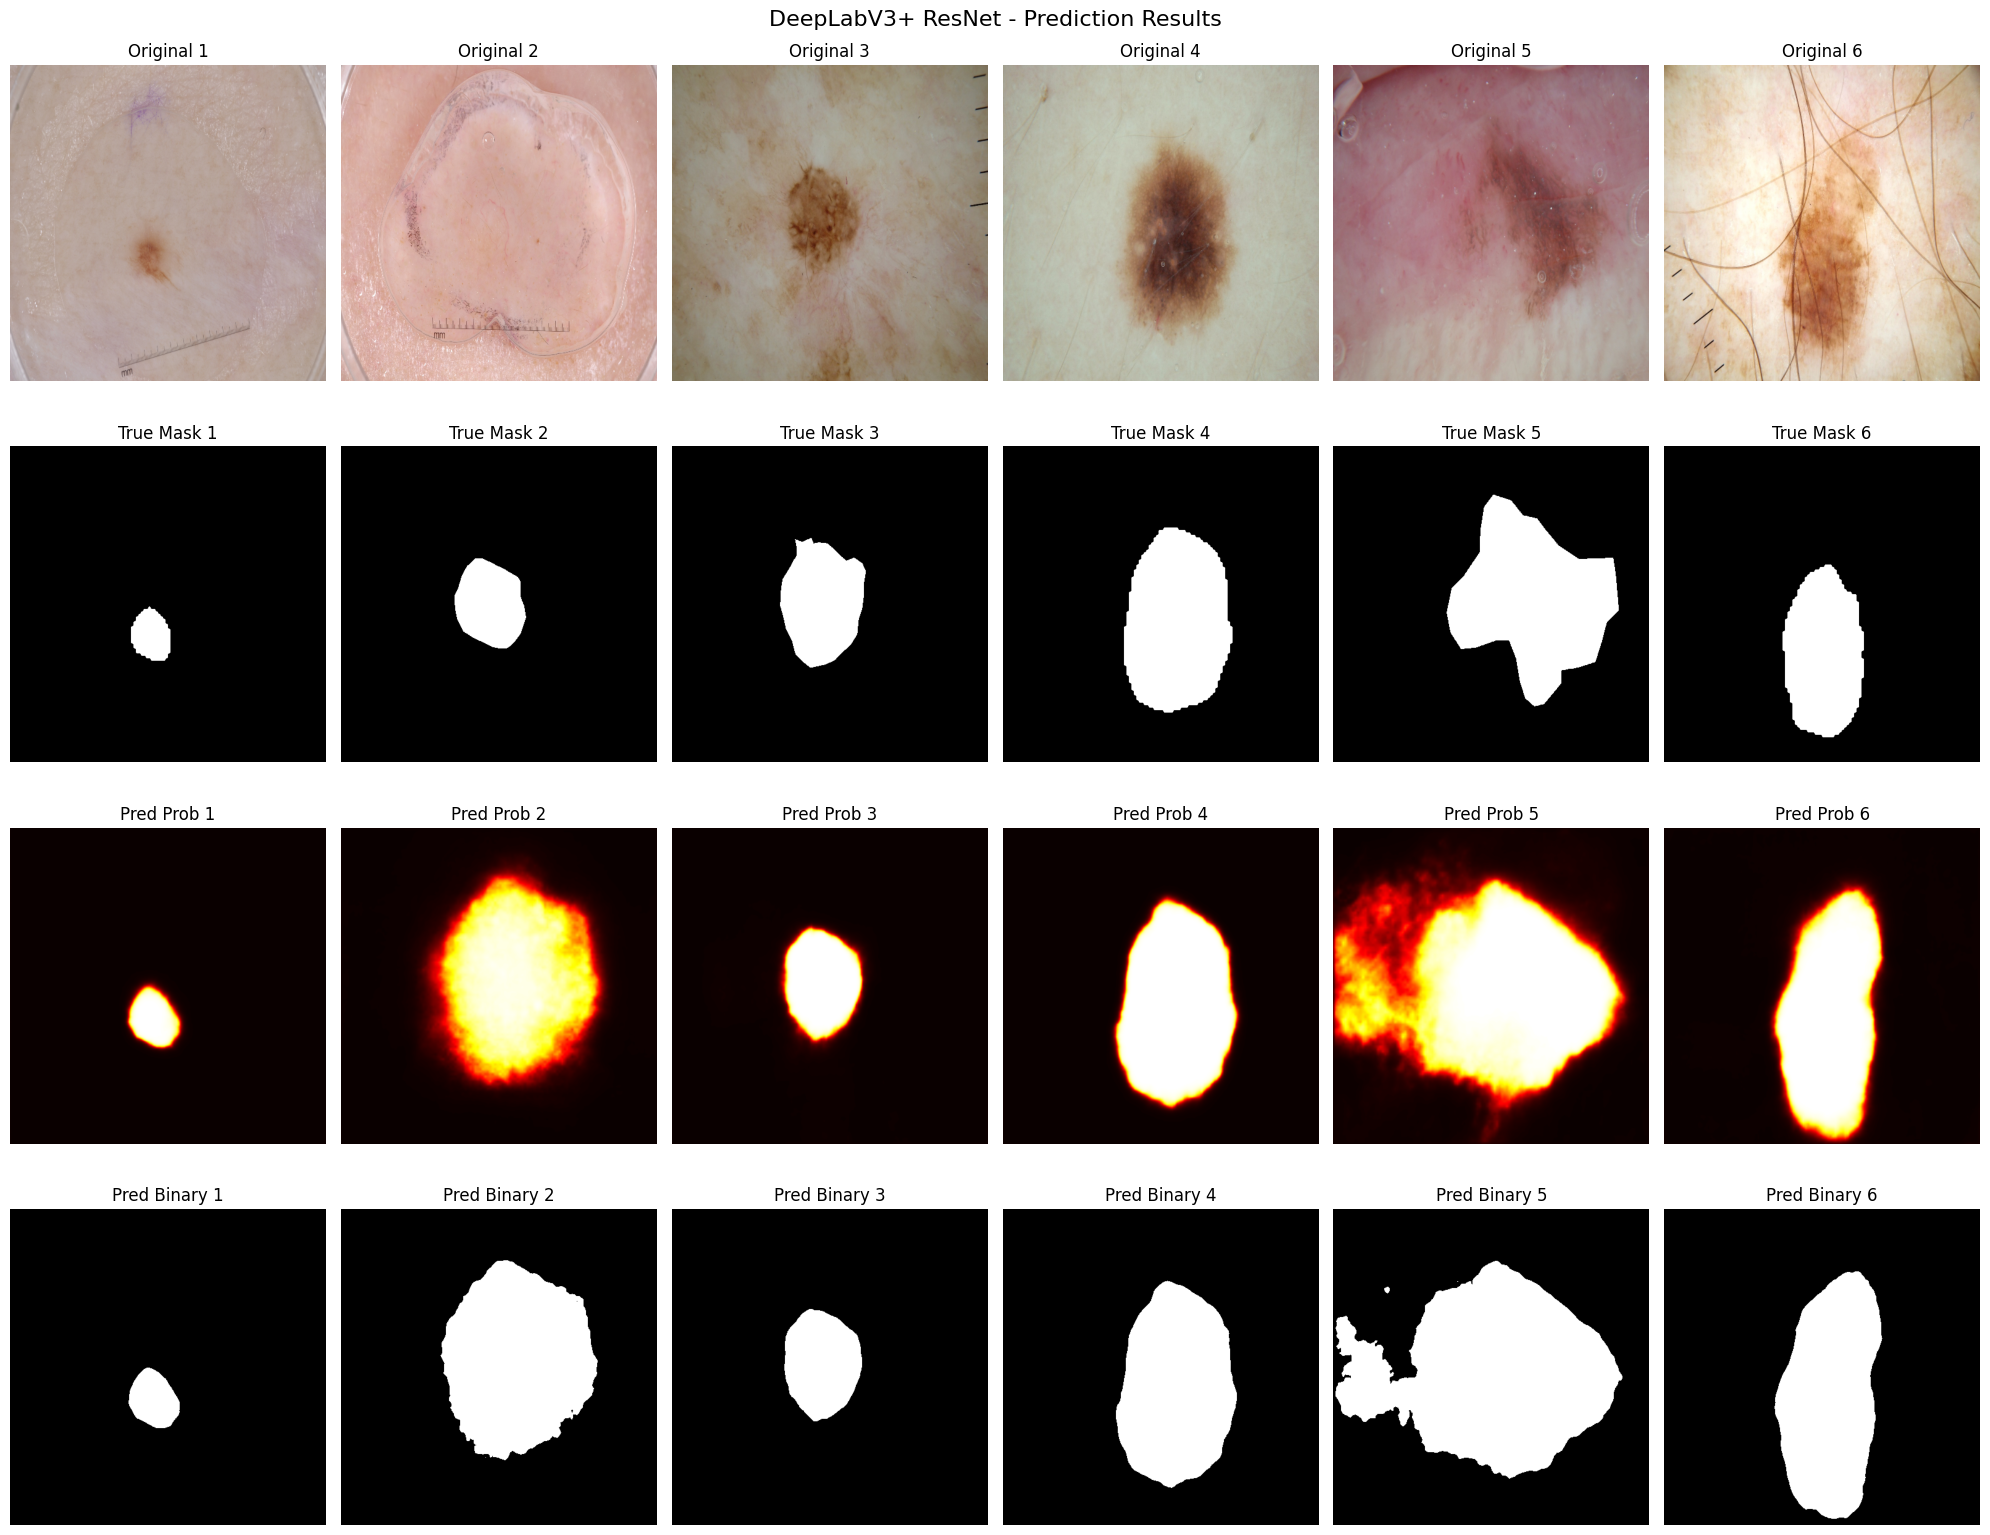

In [18]:
def evaluate_model_on_samples(model, val_loader, num_samples=6):
    """Evaluate model on sample images"""
    model.eval()
    
    # Get some samples
    samples = []
    with torch.no_grad():
        for i, (images, masks) in enumerate(val_loader):
            if i >= num_samples // val_loader.batch_size + 1:
                break
                
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            
            for j in range(min(images.shape[0], num_samples - len(samples))):
                # Denormalize image for visualization
                img = images[j].cpu()
                mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
                std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
                img = img * std + mean
                img = torch.clamp(img, 0, 1)
                
                # Handle different tensor shapes
                if masks.dim() == 3:  # [batch, H, W]
                    true_mask = masks[j].cpu().numpy()
                else:  # [batch, 1, H, W]
                    true_mask = masks[j, 0].cpu().numpy()
                
                if outputs.dim() == 3:  # [batch, H, W]
                    pred_mask = outputs[j].cpu().numpy()
                    pred_binary = (outputs[j] > 0.5).cpu().numpy().astype(np.uint8)
                else:  # [batch, 1, H, W]
                    pred_mask = outputs[j, 0].cpu().numpy()
                    pred_binary = (outputs[j, 0] > 0.5).cpu().numpy().astype(np.uint8)
                
                samples.append({
                    'image': img.permute(1, 2, 0).numpy(),
                    'true_mask': true_mask,
                    'pred_mask': pred_mask,
                    'pred_binary': pred_binary
                })
                
                if len(samples) >= num_samples:
                    break
    
    # Visualize results
    fig, axes = plt.subplots(4, len(samples), figsize=(20, 16))
    
    for i, sample in enumerate(samples):
        # Original image
        axes[0, i].imshow(sample['image'])
        axes[0, i].set_title(f'Original {i+1}')
        axes[0, i].axis('off')
        
        # True mask
        axes[1, i].imshow(sample['true_mask'], cmap='gray')
        axes[1, i].set_title(f'True Mask {i+1}')
        axes[1, i].axis('off')
        
        # Predicted mask (probability)
        axes[2, i].imshow(sample['pred_mask'], cmap='hot', vmin=0, vmax=1)
        axes[2, i].set_title(f'Pred Prob {i+1}')
        axes[2, i].axis('off')
        
        # Predicted mask (binary)
        axes[3, i].imshow(sample['pred_binary'], cmap='gray')
        axes[3, i].set_title(f'Pred Binary {i+1}')
        axes[3, i].axis('off')
    
    plt.suptitle('DeepLabV3+ ResNet - Prediction Results', fontsize=16)
    plt.tight_layout()
    plt.show()

# Evaluate model on samples
print("🔍 Đánh giá model trên validation samples:")
evaluate_model_on_samples(model, val_loader, num_samples=6)

## 8. Final Results Summary

In [19]:
# Print final results
print("🎯 DEEPLABV3+ RESNET TRAINING RESULTS")
print("=" * 50)
print(f"📊 Final Metrics (Last Epoch):")
print(f"   - Training Loss: {deeplabv3_resnet_history['train_losses'][-1]:.4f}")
print(f"   - Validation Loss: {deeplabv3_resnet_history['val_losses'][-1]:.4f}")
print(f"   - Training Dice: {deeplabv3_resnet_history['train_dice'][-1]:.4f}")
print(f"   - Validation Dice: {deeplabv3_resnet_history['val_dice'][-1]:.4f}")
print(f"   - Training Jaccard: {deeplabv3_resnet_history['train_jaccard'][-1]:.4f}")
print(f"   - Validation Jaccard: {deeplabv3_resnet_history['val_jaccard'][-1]:.4f}")

print(f"\n🏆 Best Metrics:")
best_val_dice_idx = np.argmax(deeplabv3_resnet_history['val_dice'])
best_val_jaccard_idx = np.argmax(deeplabv3_resnet_history['val_jaccard'])
print(f"   - Best Validation Dice: {max(deeplabv3_resnet_history['val_dice']):.4f} (Epoch {best_val_dice_idx + 1})")
print(f"   - Best Validation Jaccard: {max(deeplabv3_resnet_history['val_jaccard']):.4f} (Epoch {best_val_jaccard_idx + 1})")

print(f"\n💾 Saved Models:")
print(f"   - models/deeplabv3_resnet_model_best.pth")
print(f"   - models/deeplabv3_resnet_model_final.pth")

print(f"\n📈 Model Performance:")
final_dice = deeplabv3_resnet_history['val_dice'][-1]
final_jaccard = deeplabv3_resnet_history['val_jaccard'][-1]

if final_dice > 0.85:
    print(f"   ✅ Excellent performance! Dice > 0.85")
elif final_dice > 0.80:
    print(f"   ✅ Good performance! Dice > 0.80")
elif final_dice > 0.75:
    print(f"   ⚠️  Acceptable performance. Dice > 0.75")
else:
    print(f"   ❌ Performance needs improvement. Dice < 0.75")

print(f"\n🎉 ALL MODELS TRAINING COMPLETED!")
print(f"\n📊 Trained Models Summary:")
print(f"   1. ✅ SegFormer (Transformer-based) - models/segformer_model_*.pth")
print(f"   2. ✅ U-Net EfficientNet (CNN-based) - models/unet_efficientnet_model_*.pth")
print(f"   3. ✅ U-Net ViT (Hybrid) - models/unet_vit_model_*.pth")
print(f"   4. ✅ DeepLabV3+ ResNet (Multi-scale) - models/deeplabv3_resnet_model_*.pth")

print(f"\n🚀 Next Steps:")
print(f"   1. Compare all models' performance")
print(f"   2. Create ensemble predictions")
print(f"   3. Evaluate on test set")
print(f"   4. Deploy best performing model")

print("\n✅ DeepLabV3+ ResNet training completed successfully!")
print("🎊 Congratulations! All 4 models have been trained successfully!")

🎯 DEEPLABV3+ RESNET TRAINING RESULTS
📊 Final Metrics (Last Epoch):
   - Training Loss: 0.0962
   - Validation Loss: 0.1228
   - Training Dice: 0.9190
   - Validation Dice: 0.9045
   - Training Jaccard: 0.8523
   - Validation Jaccard: 0.8275

🏆 Best Metrics:
   - Best Validation Dice: 0.9045 (Epoch 15)
   - Best Validation Jaccard: 0.8275 (Epoch 15)

💾 Saved Models:
   - models/deeplabv3_resnet_model_best.pth
   - models/deeplabv3_resnet_model_final.pth

📈 Model Performance:
   ✅ Excellent performance! Dice > 0.85

🎉 ALL MODELS TRAINING COMPLETED!

📊 Trained Models Summary:
   1. ✅ SegFormer (Transformer-based) - models/segformer_model_*.pth
   2. ✅ U-Net EfficientNet (CNN-based) - models/unet_efficientnet_model_*.pth
   3. ✅ U-Net ViT (Hybrid) - models/unet_vit_model_*.pth
   4. ✅ DeepLabV3+ ResNet (Multi-scale) - models/deeplabv3_resnet_model_*.pth

🚀 Next Steps:
   1. Compare all models' performance
   2. Create ensemble predictions
   3. Evaluate on test set
   4. Deploy best perfor